In [189]:
### PYMOO
from pymoo.core.problem import Problem, ElementwiseProblem, StarmapParallelization
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.util.display.multi import MultiObjectiveOutput
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation
from pymoo.indicators.hv import HV
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.termination import get_termination

#multiprocessamento e outros
from tqdm.notebook import trange, tqdm
import multiprocessing, requests, sys, time, itertools, dill, random, os, pickle, copy

#Pandas, SKLearn e etc.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score

#Goatools e Gontosim
from goatools.obo_parser import GODag
from goatools.base import get_godag
#go = get_godag("go-basic.obo", optional_attrs={'relationship'})
from Similarity import Similarity_of_Two_GOTerms, Similarity_of_Set_of_GOTerms
from sklearn.ensemble import RandomForestClassifier

from skrebate import ReliefF

'''Constantes'''
MIN_FEATURES = 1
MAX_FEATURES = 100

In [2]:
data = pd.read_pickle('Data/data_Breast_GSE70947_norm.pkl')
colunas = data.columns.drop(['type']).tolist()

affymetrix_similarity = pd.read_pickle('./Data/Breast_GSE70947-gene_symbols.pkl')
go_completeness = dict(zip(affymetrix_similarity['feature'], affymetrix_similarity['scores']))
go_completeness_breast_cancer = dict(zip(affymetrix_similarity['feature'], affymetrix_similarity['scores_breast_cancer_pathways']))
del go_completeness['type']
del go_completeness_breast_cancer['type']
X = data[colunas]
y = data['type']

In [3]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X, y)

RandomForestClassifier(n_estimators=1000)

In [195]:
# Inicializar o ReliefF
relieff = ReliefF(n_features_to_select=10, n_neighbors=10)  # Ajuste os parâmetros conforme necessário

# Ajustar o modelo e calcular as pontuações das características
relieff.fit(np.array(X), np.array(y))

# Obter as pontuações das características
sc_relieff = relieff.feature_importances_

In [4]:
def getSparseEAWeight(X, y):
    X = np.array(X)
    weights = []
    for i in trange(len(X[0])):
        f_1 = []
        n_tests = 5
        seed = 41
        X_selected = X[:,i]
        for i in range(n_tests):
            seed = seed + 1
            skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True) # Kfolding usado para separar em treino e teste
            clf = svm.SVC(kernel='linear') # treino usando modelo SVM
            f_1.append(np.mean(cross_val_score(clf, X_selected.reshape(-1, 1), y, cv=skf, scoring='f1_macro', n_jobs = 10))) # Computar f1
        
        weights.append(round(np.array(f_1).sum()/n_tests, 3))
    return weights
###sc = getSparseEAWeight(X,y)
with open('Data/sc.pkl', 'rb') as file:
    sc = pickle.load(file)

In [209]:
class BinaryDistributedWeightsSampling(Sampling):
    def __init__(self, **kwargs):
        self.sampling_weights = kwargs.pop('sampling_weights', None)
        self.seed = kwargs.pop('seed', 42)
        super().__init__(**kwargs)
        
    def _do(self, problem, n_samples, **kwargs):
        random.seed(self.seed)
        population = []
        for i in range(n_samples):
            trues = np.random.randint(1, MAX_FEATURES + 1)
            individual = np.full(len(colunas), False)
            individual[random.choices(range(len(colunas)), weights = self.sampling_weights, k=trues)] = True
            population.append(individual)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        print(sorted(row_sums))
        return population

class SparseEASampling(Sampling):
    def __init__(self, **kwargs):
        self.sc = kwargs.pop('sc', None)
        self.seed = kwargs.pop('seed', 42)
        super().__init__(**kwargs)
        
    def _do(self, problem, n_samples, **kwargs):
        random.seed(self.seed)
        population = []
        for i in range(n_samples):
            trues = np.random.randint(1, MAX_FEATURES + 1)
            individual = np.full(len(colunas), False)
            
            for j in range(trues):
                candidates = random.choices(range(len(colunas)), k = 2)
                if self.sc[candidates[0]] > self.sc[candidates[1]]:
                    individual[candidates[0]] = True
                else:
                    individual[candidates[1]] = True

            population.append(individual)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        print(sorted(row_sums))
        return population

class ReliefFSampling(Sampling):
    def __init__(self, **kwargs):
        self.sc = kwargs.pop('sc', None)
        self.seed = kwargs.pop('seed', 42)
        super().__init__(**kwargs)
        
    def tournament_selection(self, num, sc):
        selected_indices = []
        for _ in range(num):
            # Escolhe dois índices aleatórios
            idx1, idx2 = np.random.choice(len(sc), size=2, replace=False)
            
            # Compara as pontuações e seleciona o índice com a maior pontuação
            if sc[idx1] > sc[idx2]:
                selected_indices.append(idx1)
            else:
                selected_indices.append(idx2)
    
        # Remove duplicatas e retorna os índices únicos
        return list(set(selected_indices))
    
    def _do(self, problem, n_samples, **kwargs):
        population = np.full((n_samples, len(colunas)), False)  # Inicializa a população com zeros
        for i in range(n_samples):
            num = np.random.randint(1, MAX_FEATURES + 1)
            selected_indices = self.tournament_selection(num, sc)
            population[i, selected_indices] = True
    
        return population
    

In [257]:
class BitflipMutationLimitedBalanced(Mutation):
    def __init__(self, **kwargs):
        self.weights = kwargs.pop('weights', None)
        super().__init__(**kwargs)
        
    def _do(self, problem, X, **kwargs):
        print('mutate', X.shape)
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        full = np.random.rand(*X.shape) < prob_var  # Evita uma criação redundante de matriz e faz o flip diretamente

        # Itera diretamente em X e full para alterar os valores
        for individual, vector in zip(X, full):
            num_changes = min(MAX_FEATURES, np.sum(vector))  # Limita a quantidade de alterações pelo MAX_FEATURES
            true_indices = np.where(individual)[0]
            false_indices = np.where(~individual)[0]
        
            # Seleciona índices aleatórios para trocar, dividindo o número de mudanças igualmente entre 'True' e 'False'
            flip_choices = np.random.rand(num_changes) < 0.5
            true_flips = np.sum(flip_choices)
            false_flips = num_changes - true_flips

            if self.weights is not None:
                weights = self.weights[false_indices]
            else:
                weights = None
            
            if true_flips > 0 and len(true_indices) > 0:
                individual[np.random.choice(true_indices, min(true_flips, len(true_indices)), replace=False)] = False
            if false_flips > 0 and len(false_indices) > 0:
                individual[random.choices(false_indices, k = min(false_flips, len(false_indices)), weights=weights)] = True

        for individual in X:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual = individual[np.random.choice(np.where(individual == True)[0], MAX_FEATURES)]
        return X


class SparseEAMutation(Mutation):
    def __init__(self, **kwargs):
        self.weights = kwargs.pop('weights', None)
        super().__init__(**kwargs)
        
    def _do(self, problem, X, **kwargs):
        print('mutate', X.shape)
        
        # Itera diretamente em X e full para alterar os valores
        for individual in X:
            true_indices = np.where(individual)[0]
            false_indices = np.where(~individual)[0]
        
            if np.random.rand() < 0.5:
                # Seleciona dois índices de variáveis não nulas
                if len(true_indices) >= 2:
                    m, n = np.random.choice(true_indices, size=2, replace=False)
                    
                    # Aplica a lógica baseada no Score
                    if self.weights[m] < self.weights[n]:
                        individual[m] = 0
                    else:
                        individual[n] = 0
            else:
                # Seleciona dois índices de variáveis nulas
                if len(false_indices) >= 2:
                    m, n = np.random.choice(false_indices, size=2, replace=False)
                    
                    # Aplica a lógica baseada no Score
                    if self.weights[m] > self.weights[n]:
                        individual[m] = 1
                    else:
                        individual[n] = 1

        for individual in X:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual = individual[np.random.choice(np.where(individual == True)[0], MAX_FEATURES)]
        return X

class ReliefFMutation(Mutation):
    def __init__(self, **kwargs):
        self.sc = kwargs.pop('sc', None)
        super().__init__(**kwargs) # Scores das features do ReliefF

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            individual = X[i, :]
            selected_indices = np.where(individual == True)[0]
            unselected_indices = np.where(individual == False)[0]
            
            # 1. Decidir se remove ou adiciona uma feature
            if np.random.rand() < 0.5 and len(selected_indices) > 1:
                # Mutação Tipo 1: Remover uma feature selecionada (menor score)
                if len(selected_indices) > 0:
                    # Torneio binário invertido (prioriza features com scores BAIXOS)
                    scores = -self.sc[np.array(selected_indices)]  # Inverte os scores
                    winner = self._binary_tournament(selected_indices, scores)
                    individual[winner] = False  # Remove a feature
            elif len(selected_indices) < MAX_FEATURES:
                # Mutação Tipo 2: Adicionar uma feature não selecionada (maior score)
                unselected_indices = np.where(individual == False)[0]
                if len(unselected_indices) > 0:
                    # Torneio binário normal (prioriza features com scores ALTOS)
                    scores = self.sc[unselected_indices]
                    winner = self._binary_tournament(unselected_indices, scores)
                    individual[winner] = True  # Adiciona a feature
            
            X[i, :] = individual
        return X

    def _binary_tournament(self, candidates, scores):
        # Escolhe 2 candidatos aleatoriamente e seleciona o com maior score
        idx = np.random.choice(len(candidates), 2, replace= True if len(candidates) == 1 else False) #Quanto tem só 1 individuo, o replace precisa ser True
        winner = candidates[idx[np.argmax(scores[idx])]]
        return winner

### Crossover

In [7]:
a = BinaryDistributedWeightsSampling()
samples = a._do(problem = problem, n_samples=10)

samples.shape

SparseEACrossover()._do(X = samples, _ = (1 ,samples.shape[0], samples.shape[1]))

NameError: name 'problem' is not defined

In [355]:
from pymoo.core.crossover import Crossover
from pymoo.util.misc import crossover_mask


class SparseEACrossover(Crossover):

    def __init__(self, **kwargs):
        self.sc = kwargs.pop('sc', None)
        super().__init__(2, 2, **kwargs)

    def _do(self, _, X, **kwargs):
        _, n_matings, n_var = X.shape
        M = np.random.random((n_matings, n_var)) < 0.5
        X_ = list(np.copy(X[0]))
        X_.extend(list(np.copy(X[1])))
        X_.extend(X_)
        O = []
        print('len X_', len(X_))
        while X_:
            # Seleciona dois pais aleatoriamente
            p_idx, q_idx = np.random.choice(len(X_), size=2, replace=False)
            p = X_.pop(max(p_idx, q_idx)) # Remove o maior primeiro
            q = X_.pop(min(p_idx, q_idx))
            # Remove os pais de P_prime
            #print('len X_', len(X_))
            o_mask = p.copy()
            # Determina se será usada a primeira ou segunda lógica
            if np.random.rand() < 0.5:
                # Seleciona duas variáveis de decisão aleatórias de p.mask ∩ q.mask
                common_indices = np.where(p & ~q)[0]
                if len(common_indices) < 2:
                    O.append(np.array(o_mask))
                    continue  # Se não houver pelo menos dois elementos em comum, pula esta iteração
                m, n = np.random.choice(common_indices, size=2, replace=False)
                # Aplica a regra com base nas pontuações
                if self.sc[m] < self.sc[n]:
                    o_mask[m] = False
                else:
                    o_mask[n] = False
            else:
                # Seleciona duas variáveis de decisão aleatórias de p.mask ∩ q.mask
                common_indices = np.where(~p & q)[0]
                if len(common_indices) < 2:
                    O.append(np.array(o_mask))
                    continue  # Se não houver pelo menos dois elementos em comum, pula esta iteração
                
                m, n = np.random.choice(common_indices, size=2, replace=False)
    
                # Aplica a regra com base nas pontuações
                if self.sc[m] > self.sc[n]:
                    o_mask[m] = True
                else:
                    o_mask[n] = True
            # Adiciona o descendente à lista de descendentes
            O.append(np.array(o_mask))
        O = np.array(O)
        print(O.shape)
        return O.reshape(2,int(O.shape[0]/2), O.shape[1])

class UniformCrossover(Crossover):

    def __init__(self, **kwargs):
        super().__init__(2, 2, **kwargs)

    def _do(self, _, X, **kwargs):
        print('crossover', X.shape)
        _, n_matings, n_var = X.shape
        M = np.random.random((n_matings, n_var)) < 0.5
        _X = crossover_mask(X, M)
        print(_X.shape)
        return _X


class UX(UniformCrossover):
    pass

class ThreeToOneCrossover(Crossover):
    def __init__(self, n_matings=None, **kwargs):
        self.sc = kwargs.pop('sc', None)
        super().__init__(n_parents=3, n_offsprings=2, **kwargs)
        self.n_matings = n_matings  # Número de "matings" (ajustado para manter a população)

    def _do(self, problem, X, **kwargs):
        # Se n_matings não for definido, usa o tamanho da população original
        X_ = list(np.copy(X[0]))
        X_.extend(list(np.copy(X[1])))
        X = np.array(X_)
        n_matings = self.n_matings if self.n_matings else X.shape[0]
        offspring = np.full((n_matings, problem.n_var), False)

        for i in range(n_matings):
            # Seleciona 3 pais aleatórios (com substituição, se necessário)
            parent_indices = np.random.choice(X.shape[0], 3, replace=True)
            parents = X[parent_indices]
            child = self._create_child(parents)
            offspring[i, :] = child

        return offspring.reshape(2,int(offspring.shape[0]/2), offspring.shape[1])

    def _create_child(self, parents):
        p1, p2, p3 = parents[0], parents[1], parents[2]
        n_features = len(p1)
        child = np.full(n_features, False)

        # Lógica do crossover 3-to-1 (como implementado anteriormente)
        L1 = np.logical_and(p1, p2)
        L2 = np.logical_and(p1, p3)
        L3 = np.logical_and(p2, p3)
        S3 = np.logical_and(L1, L2, L3)
        child[S3] = True

        S2_candidates = (L1 | L2 | L3) & ~S3
        S2_indices = np.where(S2_candidates)[0]
        if len(S2_indices) > 0:
            idx = np.random.choice(S2_indices, 2, replace=True if len(S2_indices) == 1 else False)
            winner = idx[np.argmax(self.sc[idx])]
            child[winner] = True

        S1_candidates = (p1 | p2 | p3) & ~S3 & ~S2_candidates
        S1_indices = np.where(S1_candidates)[0]
        if len(S1_indices) > 0:
            idx = np.random.choice(S1_indices, 2, replace=True if len(S1_indices) == 1 else False)
            loser = idx[np.argmin(self.sc[idx])]
            child[loser] = False

        return child

In [157]:
class GeneSelection(ElementwiseProblem):
    def __init__(self, X, y, runner):
        self.n_features = X.shape[1]
        self.eval_dict = {'n_features':[], 'f1_score':[]}
        super().__init__(   n_var=self.n_features,
    						n_obj=2,
    						n_constr=2,
    						xl=np.zeros(self.n_features),
    						xu=np.ones(self.n_features),
    						elementwise_evaluation=True,
                            type_var=bool,
                            save_history=True,
                            elementwise_runner=runner)

    def _evaluate(self, x, out, *args, **kwargs):
        selected_features = np.where(x == 1)[-1] # seleciona as features de acordo com o vetor binário
        X_selected = X_worker[:,selected_features]
        f_1 = []
        n_tests = 5
        seed = 41
        
        
        if len(selected_features) > 0:
            for i in range(n_tests):
                seed = seed + 1
                skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True) # Kfolding usado para separar em treino e teste
                clf = svm.SVC(kernel='linear') # treino usando modelo SVM
                f_1.append(np.mean(cross_val_score(clf, X_selected, y_worker, cv=skf, scoring='f1_macro'))) # Computar f1
        
        f_1 = round(np.array(f_1).sum()/n_tests, 3)
        n_features = len(selected_features)
        # salvar os resultados
        self.eval_dict['n_features'].append(n_features)
        self.eval_dict['f1_score'].append(f_1)
        out["F"] = [n_features, -f_1] # define os objetivos a serem minimizados
        # Restrições: limite mínimo e máximo de features selecionadas
        g1 = MIN_FEATURES - n_features  # Deve ser <= 0
        g2 = n_features - MAX_FEATURES  # Deve ser <= 0
        out["G"] = np.column_stack([g1, g2])
        

In [158]:
def _init_evaluator():
    global pid_, X_worker, y_worker, colunas_worker
    pid_ = os.getpid()
    X_worker = np.array(X.copy())
    y_worker = np.array(y.copy())
    colunas_worker = colunas.copy()

In [98]:
try:
    pool.close()
    _pool.close()
except:
    pass
n_proccess = 48
pool = multiprocessing.Pool(n_proccess, initializer=_init_evaluator)
runner = StarmapParallelization(pool.starmap)

In [361]:
problem = GeneSelection(X,y.values, runner)
algorithm = NSGA2(
    pop_size=100,
    sampling=ReliefFSampling(sc = sc_relieff),
    crossover=ThreeToOneCrossover(sc = sc_relieff),
    mutation=ReliefFMutation(sc = sc_relieff),
    eliminate_duplicates = False
)

In [362]:
res = minimize(problem, algorithm, ("n_gen", 10), seed=41, save_history=True, verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      9 |  0.000000E+00 |  0.000000E+00 |             - |             -
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(100, 35981)
     2 |      200 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0217391304 |         ideal
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(100, 35981)
     3 |      300 |      6 |  0.000000E+00 |  0.000000E+00 |  0.6000000000 |         nadir
[[False False False ... False False False]
 [False False False ... False False Fal

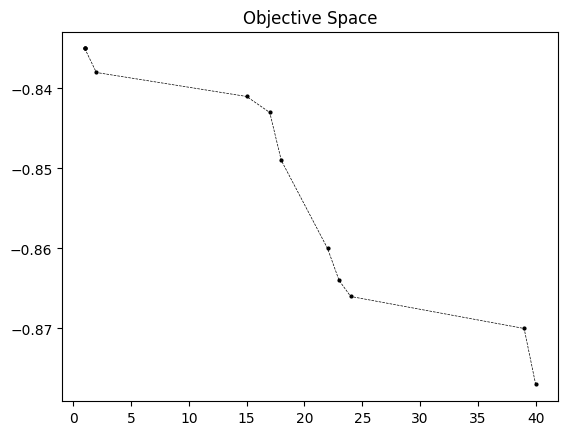

In [363]:
plot_pareto_front(res, color = 'black')

In [150]:
def run_experiment(**kwargs):
    problem = kwargs.get('problem', None)
    n_population = kwargs.get('n_population', 100)
    n_gen = kwargs.get('n_gen', 100)
    sampling = kwargs.get('sampling', None)
    seed = kwargs.get('seed', 42)
    crossover = kwargs.get('crossover', UniformCrossover())
    mutation = kwargs.get('mutation', None)
    max_features = kwargs.get('max_features', 100)
    verbose = kwargs.get('verbose', True)
    algorithm = kwargs.get('algorithm', None)
    
    algorithm = algorithm(pop_size = n_population,
                      sampling = sampling,
                	  crossover = crossover,
                	  mutation = mutation,
                      save_history = True)
    
    result = minimize(problem,  # problem class
                      algorithm,  # algorithm
                      ("n_gen", n_gen), # number of iteration for eval problem class
                      verbose=verbose)
    return result


In [ ]:
result = run_experiment(problem = problem,
               algorithm = SPEA2,
               n_population = 100,
               n_gen = 10,
               sampling = BinaryDistributedWeightsSampling(),
               seed = 42,
               mutation = BitflipMutation(),
               max_features = 100)

In [102]:
def plot_result(result, **kwargs):
    color = kwargs.get('color', 'black')
    alpha = kwargs.get('alpha', 0.8)
    n_evals = np.array([e.evaluator.n_eval for e in result.history])
    opt = np.array([e.opt[0].F for e in result.history])
    X_res, F_res = result.opt.get("X", "F")
            
    hist = result.history
    max = 100
    ref_point = np.array([15, -0.75])
    ind = HV(ref_point=ref_point)
            
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
            
    for algo in hist:
        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)
            
        # retrieve the optimum from the algorithm
        opt = algo.opt
            
        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())
            
        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
        
    metric = HV(ref_point= ref_point,
                                 norm_ref_point=False)
        
    hv = [metric.do(_F)/max for _F in hist_F]
        
    #plt.figure(figsize=(7, 5))
    plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop", alpha = alpha)
    plt.scatter(n_evals, hv,  facecolor="none", edgecolor=color, marker="p", alpha = alpha)
    plt.title("Convergence")
    plt.xlabel("Function Evaluations")
    plt.ylabel("Hypervolume")
    return hv[-1]

def plot_pareto_front(result, **kwargs):
    color = kwargs.get('color', 'black')
    #plt.figure(figsize=(7, 5))
    F_res = result.opt.get("F")
    plt.plot(F_res[:, 0][np.argsort(F_res[:, 1])], F_res[:, 1][np.argsort(F_res[:, 1])], color = color,  marker='o', mfc=color, mec=color, ms=2, ls='--', lw=0.5, zorder=2)
    plt.title("Objective Space")

In [103]:

def plot_multiple_pareto_front(results, **kwargs):
    color = kwargs.get('color', 'black')
    title = kwargs.get('title', 'Mean Pareto Front')
    label = kwargs.get('label', '-')
    #plt.figure(figsize=(7, 5))
    F_res = []
    for result in results:
        F_res.extend(list(result.opt.get("F"))) 
    F_res = np.array(F_res)
    unique_keys = np.unique(F_res[:, 0])
    F_res = np.array([[key, F_res[F_res[:, 0] == key, 1].mean()] for key in unique_keys])
    plt.plot(F_res[:, 0][np.argsort(F_res[:, 0])], F_res[:, 1][np.argsort(F_res[:, 0])], color = color,  marker='o', mfc=color, mec=color, ms=2, ls='--', lw=0.5, zorder=2, label=label)
    plt.title(title)
    plt.legend(loc="upper right")


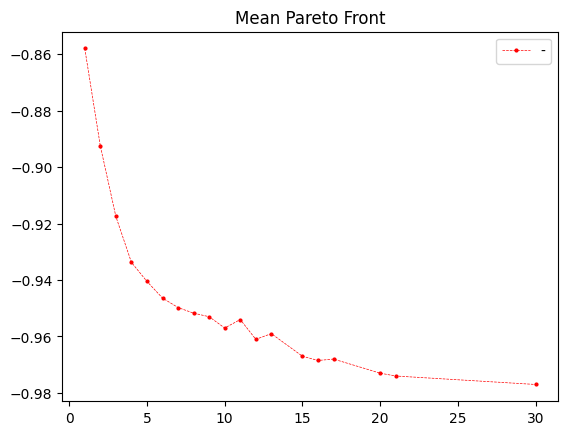

In [130]:
plot_multiple_pareto_front(nsga2_weights, color = 'red')

In [369]:
nsga2_weights = []
mofs_rfga = []

for i in tqdm(range(1)):
    result = run_experiment(problem = problem,
            algorithm = NSGA2,
            n_population = 100,
            n_gen = 50,
            sampling = BinaryDistributedWeightsSampling(sampling_weights = sc_relieff),
            seed = i,
            mutation = BitflipMutationLimitedBalanced(weights = sc_relieff),
            crossover = UniformCrossover(),
            max_features = 100)
    nsga2_weights.append(result)

    result = run_experiment(problem = problem,
               algorithm = NSGA2,
               n_population = 100,
               n_gen = 50,
               sampling = ReliefFSampling(sc = sc_relieff),
               seed = i,
               mutation = ReliefFMutation(sc = sc_relieff),
               crossover = ThreeToOneCrossover(sc = sc_relieff),
               max_features = 100)
    mofs_rfga.append(result)

    

  0%|          | 0/1 [00:00<?, ?it/s]

[1, 2, 2, 3, 5, 5, 6, 7, 11, 11, 12, 13, 14, 16, 17, 17, 18, 19, 20, 20, 21, 21, 22, 23, 24, 28, 30, 31, 34, 36, 37, 38, 39, 39, 40, 40, 41, 42, 43, 44, 45, 46, 46, 47, 48, 48, 48, 50, 51, 51, 52, 52, 54, 56, 56, 58, 60, 61, 62, 63, 63, 64, 65, 66, 66, 69, 69, 70, 71, 71, 72, 73, 75, 75, 75, 75, 76, 76, 76, 79, 82, 82, 83, 83, 84, 84, 85, 88, 88, 89, 91, 91, 92, 94, 94, 94, 96, 98, 98, 99]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      8 |  0.000000E+00 |  0.000000E+00 |             - |             -
crossover (2, 50, 35981)
(2, 50, 35981)
mutate (100, 35981)
crossover (2, 3, 35981)
(2, 3, 35981)
mutate (6, 35981)
     2 |      200 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0268817204 |         ideal
crossover (2, 50, 35981)
(2, 50, 35981)
mutate (100, 35981)
crossover (2, 3, 35981)
(2, 3, 35981)
mutate (6, 35981)
     3 |      300 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0412371134 |         ideal
crossover (

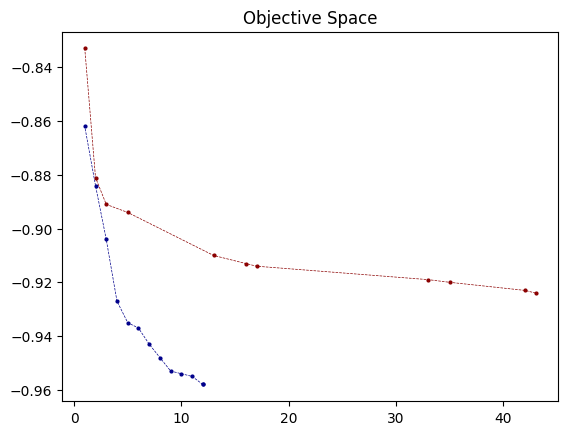

In [370]:
for experiment in nsga2_weights:
    plot_pareto_front(experiment, color = 'darkblue')
for experiment in mofs_rfga:
    plot_pareto_front(experiment, color = 'darkred')



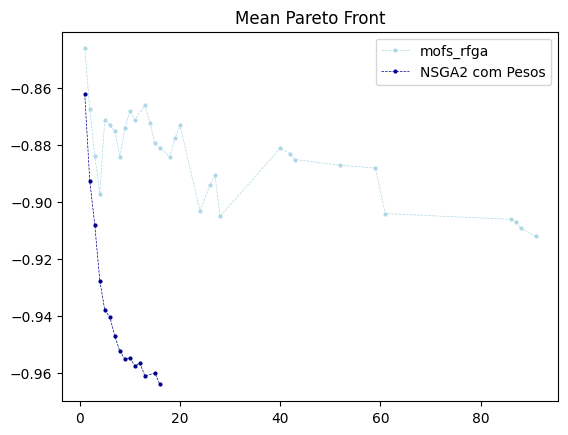

In [368]:
plot_multiple_pareto_front(mofs_rfga, color = 'lightblue', label = 'mofs_rfga')
plot_multiple_pareto_front(nsga2_weights, color = 'darkblue', label = 'NSGA2 com Pesos')

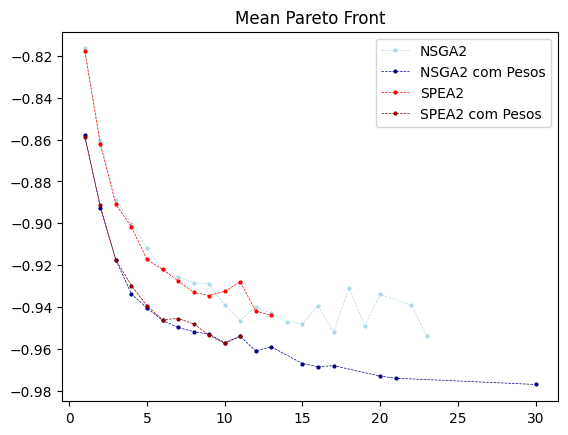

In [132]:
plot_multiple_pareto_front(nsga2, color = 'lightblue', label = 'NSGA2')
plot_multiple_pareto_front(nsga2_weights, color = 'darkblue', label = 'NSGA2 com Pesos')
plot_multiple_pareto_front(spea2, color = 'red', label = 'SPEA2')
plot_multiple_pareto_front(spea2_weights, color ='darkred', label = 'SPEA2 com Pesos')

In [ ]:
nsga2 = []
spea2 = []
nsga2_weights = []
sparseEA = []

for i in tqdm(range(10)):
    result = run_experiment(problem = problem,
               algorithm = NSGA2,
               n_population = 100,
               n_gen = 100,
               sampling =  SparseEASampling(sc = sc),
               seed = i,
               mutation = SparseEAMutation(weights = sc),
               crossover = SparseEACrossover(sc = sc),
               max_features = 100)
    sparseEA.append(result)
    
    result = run_experiment(problem = problem,
               algorithm = NSGA2,
               n_population = 100,
               n_gen = 100,
               sampling = BinaryDistributedWeightsSampling(),
               seed = i,
               mutation = BitflipMutationLimitedBalanced(),
               crossover = UniformCrossover(),
               max_features = 100)
    nsga2.append(result)
    
    result = run_experiment(problem = problem,
               algorithm = NSGA2,
               n_population = 100,
               n_gen = 100,
               sampling = BinaryDistributedWeightsSampling(sampling_weights = clf.feature_importances_),
               seed = i,
               mutation = BitflipMutationLimitedBalanced(weights = clf.feature_importances_),
               crossover = UniformCrossover(),
               max_features = 100)
    nsga2_weights.append(result)

    result = run_experiment(problem = problem,
               algorithm = SPEA2,
               n_population = 100,
               n_gen = 100,
               sampling = BinaryDistributedWeightsSampling(),
               seed = i,
               mutation = BitflipMutation(),
               crossover = UniformCrossover(),
               max_features = 100)
    spea2.append(result)

    

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 3, 4, 4, 6, 7, 7, 7, 9, 10, 10, 11, 11, 12, 12, 14, 17, 19, 19, 19, 20, 20, 22, 22, 23, 24, 26, 26, 26, 27, 27, 29, 29, 31, 33, 34, 34, 34, 36, 36, 37, 38, 38, 39, 40, 43, 43, 43, 43, 43, 44, 44, 46, 46, 47, 47, 51, 52, 53, 54, 54, 56, 56, 57, 57, 58, 59, 61, 62, 62, 65, 66, 67, 68, 68, 69, 70, 71, 72, 74, 77, 78, 79, 79, 80, 80, 81, 82, 82, 82, 84, 85, 86, 86, 87, 89, 90, 92, 96, 97]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      9 |  0.000000E+00 |  0.000000E+00 |             - |             -
len X_ 200
(100, 35981)
mutate (100, 35981)
len X_ 4
(2, 35981)
mutate (2, 35981)
     2 |      200 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0625000000 |         ideal
len X_ 200
(100, 35981)
mutate (100, 35981)
len X_ 12
(6, 35981)
mutate (6, 35981)
     3 |      300 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0409072195 |             f
len X_ 200
(100, 35981)
mutate (100, 35981)
len X_ 16
(8, 35981)
mutate (8, 359

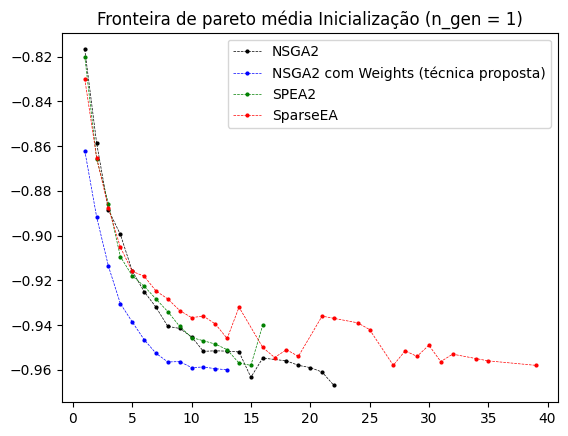

In [167]:
plot_multiple_pareto_front(nsga2, color = 'black', label = 'NSGA2')
plot_multiple_pareto_front(nsga2_weights, color = 'blue', label = 'NSGA2 com Weights (técnica proposta)')
plot_multiple_pareto_front(spea2, color = 'green', label = 'SPEA2')
plot_multiple_pareto_front(sparseEA, color = 'red', label = 'SparseEA', title = 'Fronteira de pareto média Inicialização (n_gen = 1)')